<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<hr>

# Proxy dataset - MTG Sentinel-4 UV-Visible-Near infrared (UVN) spectrometer - Nitrogen Dioxide (NO2)

### About

The geostationary [Sentinel-4](https://www.eumetsat.int/sentinel-4) mission will provide hourly data on tropospheric constituents over Europe for air quality applications.  The target species of the Sentinel-4 mission include key air quality parameters such as nitrogen dioxide, ozone, sulphur dioxide, formaldehyde, glyoxal, and aerosols. These species will be monitored by the [Sentinel-4 UVNS instrument](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-4/instrumental-payload) aboard the MTG Sounder satellite.

This notebook provides you an introduction to [European Air Quality Forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) from the Copernicus Atmosphere Monitoring Service (CAMS) and [ERA5 reanalysis](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview) data from the Copernicus Climate Change Service (C3S). A combination of these two dataset can be used as a proxy for data from the geostationary Sentinel-4 mission. 

The event that this notebook hightlights are the fires in Gironde, France in August 2022.

`Nitrogen dioxide` is a useful indicator of smoke presence and transport.


### Basic Facts

**CAMS European Air Quality Forecasts**
> **Spatial resolution**: `0.1° x 0.1°` <br>
> **Spatial coverage**: `Europe` <br>
> **Temporal resolution**:  `1-hourly up to leadtime hour 120` <br>
> **Temporal coverage**: `three-year rolling archive` <br>
> **Data format**: `GRIB` or `zipped NetCDF`

**C3S ERA5 reanalysis**
> **Spatial resolution**: `0.25° x 0.25°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `1-hourly` <br>
> **Temporal coverage**: `since 1950` <br>
> **Data format**: `GRIB` or `NetCDF`



### How to access the data

**Copernicus Atmosphere Data Store (ADS)**
CAMS European air quality forecasts are available for download via the [Copernicus Atmosphere Data Store (ADS)](https://ads.atmosphere.copernicus.eu/). You will need to create an ADS account [here](https://ads.atmosphere.copernicus.eu/user/register).

Data from the ADS can be downloaded in two ways:
* `manually` via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)
* `programmatically` with a Python package called cdsapi ([more information](https://ads.atmosphere.copernicus.eu/api-how-to))

**Copernicus Climate Change Service**
C3S ERA5 reanalysis are available for download via the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home/). You will need to create a CDS account [here](https://cds.climate.copernicus.eu/user/register).

Data from the CDS can be downloaded in two ways:
* `manually` via the [CDS web interface](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)
* `programmatically` with a Python package called cdsapi ([more information](https://cds.climate.copernicus.eu/api-how-to))

### Module outline
* [1 - CAMS European air quality forecasts](#cams_eu_forecasts)
* [2 - Copernicus ERA-5 climate reanalysis data](#era5)
* [3 - Cloud masking](#cloud_masking)
* [4 - Visualize Total Column Nitrogen Dioxide on 10 August 2022 for one time step](#visualise)
* [5 - Animate Total Column Nitrogen Dioxide over 24 hours](#animate_s4_no2_proxy)

<hr>

##### Load required libraries

In [1]:
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

# Python libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
from matplotlib.axes import Axes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from IPython.display import HTML

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

##### Load helper functions

In [2]:
%run ./functions.ipynb

<hr>

## <a id='cams_eu_forecasts'>1. CAMS European air quality forecasts

### <a id='retrieve_cams_eu_forecasts'></a>Retrieve CAMS European air quality forecasts from the Atmosphere Data Store

[OPTIONAL] The first step is to programmatically download the Nitrogen Dioxide analysis information as part of the European Air Quality Forecasts dataset. This step is optional because we have already downloaded the data for you, which is why the following code is commented out. The retrieve request below requests the following data:
> **Date**: 10 August 2022 <br>
> **Variable**: Nitrogen Dioxide<br>
> **Model**: EURAD-IM <br>
> **Type**: Analysis <br>
> **Pressure level**: [5000, 3000, 2000, 1000, 500, 250, 50, 0] <br>
> **Spatial resolution**: 0.1 deg x 0.1 deg <br>
> **Temporal resolution**: hourly <br>
> **Format**: netcdf <br>

The data is downloaded with the filename `202208_euradim_no2.nc`.

**Note:** Replace the hashes with your ADS credentials. You can find them [here](https://ads.atmosphere.copernicus.eu/api-how-to), once you are logged in.

In [3]:
URL = '#################################'
KEY = '#################################'

In [ ]:
'''
import cdsapi
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': 'euradim',
        'date': '2022-08-10/2022-08-10',
        'format': 'netcdf',
        'type': 'analysis',
        'variable': 'nitrogen_dioxide',
        'level': [
            '0', '1000', '2000',
            '250', '3000', '50',
            '500', '5000',
        ],
        'leadtime_hour': '0',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
    },
    './20220810_euradim_no2.nc')
'''

<br>

### <a id='load_browse_cams_forecast'></a>Load and browse CAMS European air quality forecasts

The next step is to open the NetCDF file as xarray Dataset. You can use the function `open_dataset()` to open a single NetCDF file. The dataset has four dimensions (`longitude`, `latitude`, `level` and `time`). A closer look at the coordinates shows that the longitude coordinates are on a grid from [0, 360]. In a next step, we can bring the longitude values to a [-180, 180] grid.

In [5]:
file_cams = xr.open_dataset('../eodata/portugal_fire_workshop/cams/euradim/20220810_euradim_no2.nc')
file_cams

<xarray.Dataset>
Dimensions:    (longitude: 700, latitude: 420, level: 8, time: 24)
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0 50.0 250.0 500.0 1e+03 2e+03 3e+03 5e+03
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant ANALYSIS at 8 levels
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20220810+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2 concentration at 8 level...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

You can use the function `assign_coords()` to reassign the longitude coordinates and shift the values to a [-180, 180] grid.

In [6]:
file_cams_assign = file_cams.assign_coords(longitude=(((file_cams.longitude + 180) % 360) - 180))
file_cams_assign

<xarray.Dataset>
Dimensions:    (longitude: 700, latitude: 420, level: 8, time: 24)
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0 50.0 250.0 500.0 1e+03 2e+03 3e+03 5e+03
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant ANALYSIS at 8 levels
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20220810+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2 concentration at 8 level...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Now, we can load the variable `no2_conc` from the xarray Dataset. You simply specify the name of the variable and bring it into square brackets. The loaded xarray.DataArray offers additional variable attributes, e.g. `species`, `units`, `value` and `standard_name`.

In [7]:
no2_conc = file_cams_assign['no2_conc']
no2_conc

<xarray.DataArray 'no2_conc' (time: 24, level: 8, latitude: 420, longitude: 700)>
[56448000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0 50.0 250.0 500.0 1e+03 2e+03 3e+03 5e+03
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
Attributes:
    species:        Nitrogen Dioxide
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_nitrogen_dioxide_in_air

<br>

In a next step, we average the Nitrogen Dioxide values over all presure levels. This operation is a simple approximation of the total column Nitrogen Dioxide content, which will be one Level 2 product offered from the Sentinel-4 mission.

In [8]:
no2_tc = no2_conc.mean('level')
no2_tc

<xarray.DataArray 'no2_conc' (time: 24, latitude: 420, longitude: 700)>
array([[[0.01432116, 0.01432233, 0.01475775, ..., 0.08047362,
         0.07923424, 0.07799472],
        [0.01432116, 0.01432116, 0.01432116, ..., 0.08335815,
         0.08335815, 0.08335815],
        [0.01432116, 0.01432116, 0.01432116, ..., 0.08335815,
         0.08335815, 0.08335815],
        ...,
        [0.03797955, 0.03729671, 0.03563292, ..., 1.6703224 ,
         1.6703224 , 1.6703224 ],
        [0.03482892, 0.03358278, 0.03355738, ..., 1.6703224 ,
         1.6703224 , 1.7568965 ],
        [0.03355738, 0.03355738, 0.03355738, ..., 1.2850963 ,
         1.6474264 , 2.434289  ]],

       [[0.01443282, 0.0144341 , 0.01491731, ..., 0.0799336 ,
         0.07828267, 0.07663544],
        [0.01443282, 0.01443282, 0.01443282, ..., 0.08376976,
         0.08376976, 0.08376976],
        [0.01443282, 0.01443282, 0.01443282, ..., 0.08376976,
         0.08376976, 0.08376976],
...
        [0.03083693, 0.03084786, 0.03096993, ..., 0.13247499,
         0.13247499, 0.13247499],
        [0.03088744, 0.03090823, 0.03090914, ..., 0.13247499,
         0.13247499, 0.13424866],
        [0.03090914, 0.03090914, 0.03090914, ..., 0.15585993,
         0.13386506, 0.14812964]],

       [[0.01053154, 0.01053176, 0.01131567, ..., 0.08774807,
         0.0868428 , 0.08594031],
        [0.01053154, 0.01053154, 0.01053154, ..., 0.08985051,
         0.08985051, 0.08985051],
        [0.01053154, 0.01053154, 0.01053154, ..., 0.08985051,
         0.08985051, 0.08985051],
        ...,
        [0.03121142, 0.0310967 , 0.03087796, ..., 0.20326947,
         0.20326947, 0.20326947],
        [0.03068181, 0.03047171, 0.03046795, ..., 0.20326947,
         0.20326947, 0.21860796],
        [0.03046795, 0.03046795, 0.03046795, ..., 0.19614244,
         0.20284602, 0.33862585]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00

Let us now visualize the Total Column Nitrogen Dioxide information at 15:00 UTC on 10 August 2022 with the pre-defined function [visualize_pcolormesh()](../functions.ipynb#visualize_pcolormesh).

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Nitrogen Dioxide at 15:00 UTC'}>)

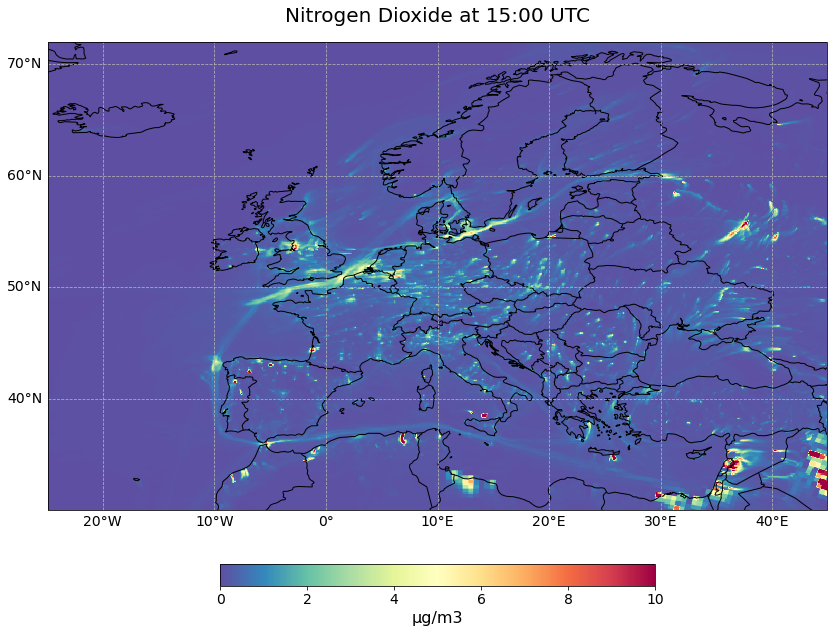

In [9]:
hour = 15
visualize_pcolormesh(data_array=no2_tc.isel(time=hour), 
                     longitude=no2_tc.longitude, 
                     latitude=no2_tc.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='Spectral_r', 
                     unit= no2_conc.units, 
                     long_name= no2_conc.species + ' at ' + str(hour) + ':00 UTC', 
                     vmin=0, 
                     vmax=10, 
                     lonmin=no2_tc.longitude.min(), 
                     lonmax=no2_tc.longitude.max(), 
                     latmin=no2_tc.latitude.min(), 
                     latmax=no2_tc.latitude.max(), 
                     set_global=False)

<br>

## <a id='era5'></a>2. Copernicus ERA-5 climate reanalysis

[OPTIONAL] The second step is now to download cloud cover information from the ERA5 climate reanalysis data for the same day, 10 August 2022 from the Copernicus Climate Data Store. This step is optional because we have already downloaded the data for you, which is why the following code is commented out. The retrieve request below downloads the following data:
> **Date**: 10 August 2022 <br>
> **Variable**: Total Cloud Cover<br>
> **Type**: Reanalysis <br>
> **Spatial resolution**: 0.25 deg x 0.25 deg <br>
> **Temporal resolution**: hourly <br>
> **Format**: netcdf <br>

The data is downloaded with the filename `20220810_era5_tcc.nc`.

**Note:** Replace the hashes with your CDS credentials. You can find them [here](https://cds.climate.copernicus.eu/api-how-to), once you are logged in.

In [ ]:
cds_url = '##############################'
cds_key = '#################################'

In [ ]:
'''
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': 'total_cloud_cover',
        'year': '2022',
        'month': '08',
        'day': '10',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            70, -25, 30,
            45,
        ],
        'format': 'netcdf',
    },
    './20220810_era5_tcc.nc')
'''

<br>

### <a id='load_era5_xarray'></a> Load and browse ERA-5 climate reanalysis data

The next step is to open the NetCDF file as xarray Dataset. You can use the function `open_dataset()` to open a single NetCDF file. The dataset has three dimensions (`longitude`, `latitude` and `time`).

In [10]:
file_cloud_cover = xr.open_dataset('../eodata/portugal_fire_workshop/era5/20220810_era5_tcc.nc')
file_cloud_cover

<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 161, time: 24)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2022-08-10 ... 2022-08-10T23:00:00
Data variables:
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-14 09:23:39 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

<br>

Now, we can load the variable `tcc` from the xarray Dataset. You simply specify the name of the variable and bring it into square brackets. The loaded xarray.DataArray offers additional variable attributes, e.g. `units`, `long_name` and `standard_name`.

In [11]:
cloud_cover = file_cloud_cover['tcc']
cloud_cover

<xarray.DataArray 'tcc' (time: 24, latitude: 161, longitude: 281)>
[1085784 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2022-08-10 ... 2022-08-10T23:00:00
Attributes:
    units:          (0 - 1)
    long_name:      Total cloud cover
    standard_name:  cloud_area_fraction

### <a id='cloud_cover_interpolate'></a> Interpolate ERA-5 data to a spatial resolution of CAMS European air quality forecasts

In a next step, we have to bring both datasets onto the same spatial resolution. For this reason, we resample the ERA5 reanalysis data to the spatial resolution of the CAMS European air quality forecasts, which is 0.1 deg x 0.1 deg.

You can use the function `interp()` to resample the coordinate of a DataArray. As target latitude and longitude information, you can provide the coordinates from the CAMS data.

In [12]:
cloud_cover_10km = cloud_cover.interp(latitude=no2_conc["latitude"], longitude=no2_conc["longitude"])
cloud_cover_10km

<xarray.DataArray 'tcc' (time: 24, latitude: 420, longitude: 700)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.39744136, 0.43184274, 0.46622312, ..., 0.        ,
         0.        , 0.        ],
        [0.38818094, 0.42027178, 0.45234305, ..., 0.        ,
         0.        , 0.        ],
        [0.3789205 , 0.40870082, 0.43846297, ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.44513065, 0.37665763, 0.3082264 , ..., 0.        ,
         0.        , 0.        ],
        [0.4793616 , 0.40481916, 0.3303222 , ..., 0.        ,
         0.        , 0.        ],
        [0.51359254, 0.43298072, 0.35241804, ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.25821003, 0.19842589, 0.13867822, ..., 0.        ,
         0.        , 0.        ],
        [0.27508193, 0.21752283, 0.15999886, ..., 0.        ,
         0.        , 0.        ],
        [0.29195383, 0.2366198 , 0.1813195 , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-10 ... 2022-08-10T23:00:00
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Attributes:
    units:          (0 - 1)
    long_name:      Total cloud cover
    standard_name:  cloud_area_fraction

<br>

Now, we can also visualize the interpolated total cloud cover for one time step. You can use again the pre-defined function [visualize_pcolormesh()](../functions.ipynb#visualize_pcolormesh).

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Total cloud cover at 15:00 UTC'}>)

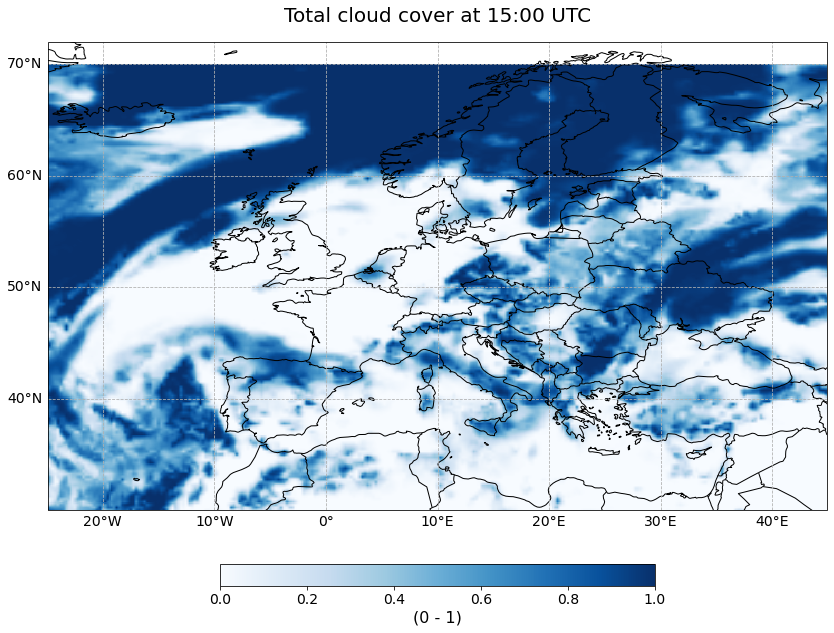

In [13]:
hour = 15
visualize_pcolormesh(data_array=cloud_cover_10km.isel(time=hour), 
                     longitude=cloud_cover_10km.longitude, 
                     latitude=cloud_cover_10km.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='Blues', 
                     unit= cloud_cover.units, 
                     long_name= cloud_cover_10km.long_name + ' at ' + str(hour) + ':00 UTC', 
                     vmin=0, 
                     vmax=1, 
                     lonmin=cloud_cover_10km.longitude.min(), 
                     lonmax=cloud_cover_10km.longitude.max(), 
                     latmin=cloud_cover_10km.latitude.min(), 
                     latmax=cloud_cover_10km.latitude.max(), 
                     set_global=False)

## <a id='cloud_masking'></a>Cloud masking

Based on the total cloud cover information, we want to filter pixels with a cloud cover less than 20%. With the function `where`, we create below a cloud mask, asigning 1 to pixels with a cloud cover less than 20%.

In [14]:
cloud_mask = xr.where(cloud_cover_10km < 0.2, 1, 0)
cloud_mask

<xarray.DataArray 'tcc' (time: 24, latitude: 420, longitude: 700)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 1, 1, 1]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-08-10 ... 2022-08-10T23:00:00
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95

<br>

Time coordinates of the CAMS European air quality forecasts are in nanoseconds. We can assign the time coordinates from the ERA-5 reanalysis data, which have a datetime format. This allows us to use the time information in the plotting title and the information is in a readable format.

In [15]:
no2_tc_assign = no2_tc.assign_coords(time=cloud_mask.time)

<br>

Now you can apply the cloud mask onto the DataArray with the Nitrogen Dioxide information. This masking process creates the proxy data for the Sentinel-4 L2 NO2 product, which will only provide information for nearly cloud-free pixels.

In [16]:
no2_tc_masked = xr.where(cloud_mask==1, no2_tc_assign, np.nan)
no2_tc_masked

<xarray.DataArray (time: 24, latitude: 420, longitude: 700)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 1.6703224 ,
         1.6703224 , 1.6703224 ],
        [       nan,        nan,        nan, ..., 1.6703224 ,
         1.6703224 , 1.7568965 ],
        [       nan,        nan,        nan, ..., 1.2850963 ,
         1.6474264 , 2.434289  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.13247499,
         0.13247499, 0.13247499],
        [       nan,        nan,        nan, ..., 0.13247499,
         0.13247499, 0.13424866],
        [       nan,        nan,        nan, ..., 0.15585993,
         0.13386506, 0.14812964]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan, 0.0310967 , 0.03087796, ..., 0.20326947,
         0.20326947, 0.20326947],
        [       nan,        nan, 0.03046795, ..., 0.20326947,
         0.20326947, 0.21860796],
        [       nan,        nan, 0.03046795, ..., 0.19614244,
         0.20284602, 0.33862585]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-10 ... 2022-08-10T23:00:00
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95

<br>

## <a id='visualise'></a> Visualize Nitrogen Dioxide on 10 August 2022 for one time step

We can now visualize the created proxy resembling Level 2 Total Column Nitrogen Dioxide data collected by the Sentinel-4 mission.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Simulated Sentinel-4 Nitrogen Dioxide \n2022-08-10 at 15:00 UTC'}>)

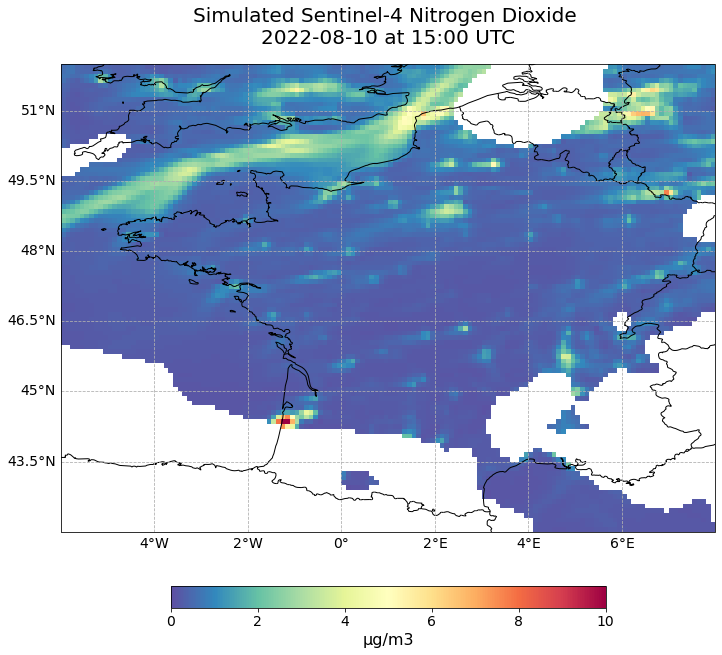

In [17]:
hour = 15
visualize_pcolormesh(data_array=no2_tc_masked.isel(time=hour), 
                     longitude=no2_tc_masked.longitude, 
                     latitude=no2_tc_masked.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='Spectral_r', 
                     unit= no2_conc.units, 
                     long_name= 'Simulated Sentinel-4 ' + no2_conc.species + ' \n' + str(no2_tc_masked.isel(time=hour).time.data)[0:10] \
                     + ' at ' + str(no2_tc_masked.isel(time=hour).time.data)[11:16] + ' UTC', 
                     vmin=0, 
                     vmax=10, 
                     lonmin=-6,
                     lonmax=8,
                     latmin=42,
                     latmax=52,
                     set_global=False)

<br>

## <a id='animate_s4_no2_proxy'></a> Animate Total Column Nitrogen Dioxide over 24 hours

In the last step, you can animate the `Nitrogen Dioxide over 24 hours` in order to see how the trace gas developed during  the 10 August 2022.

You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [18]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=no2_tc_masked[0,:,:],
                               longitude=no2_tc_masked.longitude, 
                               latitude=no2_tc_masked.latitude,
                               projection=ccrs.PlateCarree(),
                               color_scale='Spectral_r', 
                               unit=no2_conc.units,
                               long_name= 'Simulated Sentinel-4 ' + no2_conc.species + ' \n' + str(no2_tc_masked.isel(time=0).time.data)[0:10] \
                               + ' at ' + str(no2_tc_masked.isel(time=0).time.data)[11:16] + ' UTC',
                               vmin=0,
                               vmax=10,
                               lonmin=-6,
                               lonmax=8,
                               latmin=42,
                               latmax=52,
                               set_global=False)

frames = 24

def draw(i):
    img = plt.pcolormesh(no2_tc_masked.longitude, 
                         no2_tc_masked.latitude, 
                         no2_tc_masked[i,:,:], 
                         cmap='Spectral_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=10,
                         shading='auto')
    
    ax.set_title('Simulated Sentinel-4 ' + no2_conc.species + ' \n' + str(no2_tc_masked.isel(time=i).time.data)[0:10] + ' at ' + str(no2_tc_masked.isel(time=i).time.data)[11:16] + ' UTC', fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())

# The following line which saves the video file is commented out
# ani.save('./2022-08-10_S4_NO2.mp4')

plt.close(fig)

2022-10-14 12:49:59,555 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-10-14 12:49:59,558 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1440x720 -pix_fmt rgba -r 1.25 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp33u1pj0_/temp.m4v
2022-10-14 12:51:39,076 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-10-14 12:51:39,078 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1440x720 -pix_fmt rgba -r 1.25 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./2022-08-10_S4_NO2.mp4


<br>

#### Play the animation video as HTML5 video

In [19]:
HTML(ani.to_html5_video())

**Return to the case study:**
- [Monitoring fires with next-generation satellites from MTG and Metop-SG: Gironde, France Wildfires Case Study](./00_gironde_application_case.ipynb#gironde_fig5)

<hr>

### References
* Generated using Copernicus Atmosphere Monitoring Service Information 2022
* Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2018): ERA5 hourly data on single levels from 1959 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). 10.24381/cds.adbb2d47

* Some code in this notebook was adapted from the following source:
    * origin: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/265_CAMS_European_air_quality_forecast_NO2_load_browse.ipynb
    * copyright: 2022, EUMETSAT
    * license: MIT
    * retrieved: 2022-06-28 by Sabrina Szeto

<hr>

<p style="text-align:right;">This project is licensed under the <a href="../LICENSE">GPL-3.0 License</a> and is developed under a Copernicus contract.

<br>